In [1]:
!pip install pytorch_lightning==0.9.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached pytorch_lightning-0.9.0-py3-none-any.whl (408 kB)
ERROR: pytorch-lightning-bolts 0.2.5rc1 has requirement pytorch-lightning>=1.0, but you'll have pytorch-lightning 0.9.0 which is incompatible.
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.0.8
    Uninstalling pytorch-lightning-1.0.8:
      Successfully uninstalled pytorch-lightning-1.0.8


In [1]:
from data_loaders import get_data_module
from utils.visualisation import showInRow
from models import get_model

from transforms.pretraining import Moco2ChestTransforms
from transforms.finetuning import ChestTransforms

from models.baseline import BaseLineClassifierAdam

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
seed_everything(12345)

12345

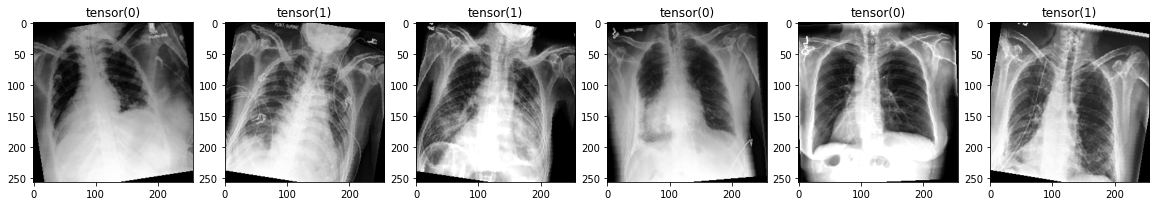

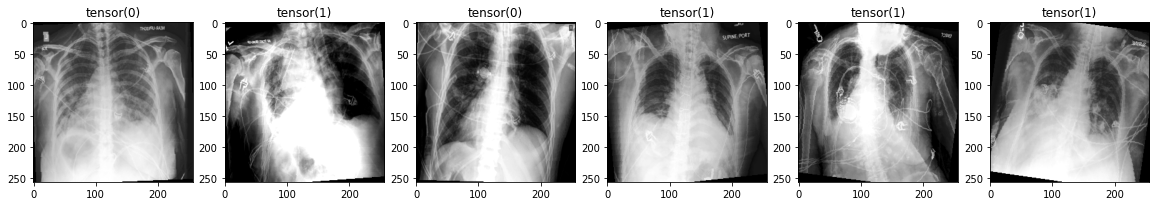

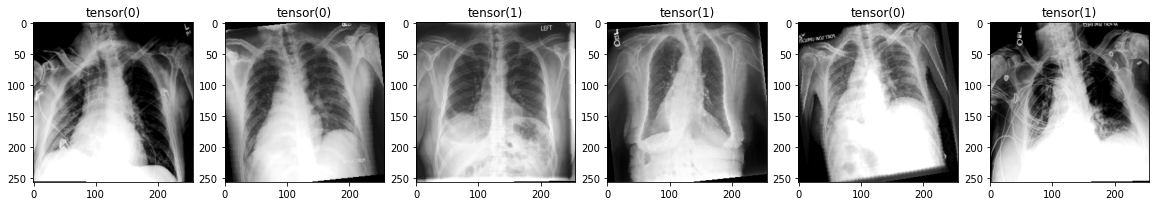

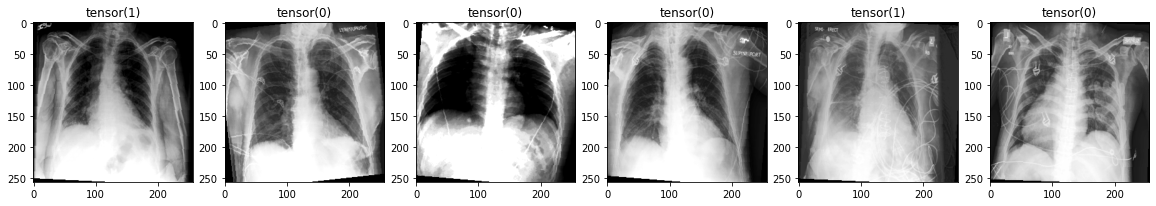

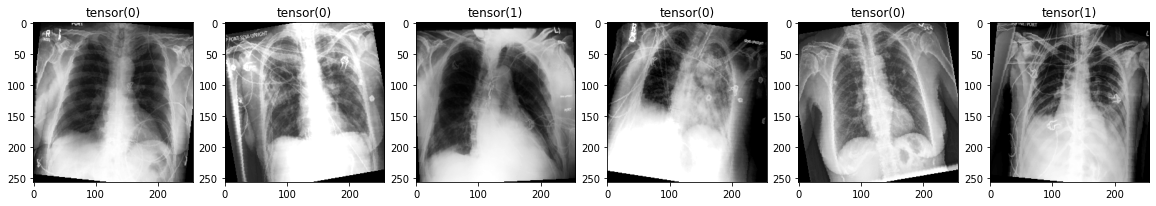

In [2]:
data_module = get_data_module("CheXpert", 
                              csv_path="/home/intern/SSL_Chest_Xray/datasets/chexpert_train_fixed.csv",
                              transform=ChestTransforms(height=256), 
                              batch_size=6,
                              target_class="Pleural Effusion",
                              seed=12345)
batches = 4
for batch in data_module.train_dataloader():
    img1, labels = batch["image"],batch['label']
    showInRow(img1, labels, tensor=True)
    batches -=  1
    if batches<0:
        break

In [3]:
classifier = BaseLineClassifierAdam(get_model("resnet18", pretrained=True), 
                                    num_classes=2, 
                                    linear=True,
                                    learning_rate=3e-5,
                                    b1=0.9,
                                    b2=0.999)

wandb_logger = WandbLogger(name='baseline_resnet_linear_chexpert_full_Adam_3e-5',project='thesis')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', 
                                      filepath = 'logs/baseline/chexpert/resnet-full-linear-adam-3e-5-{epoch:02d}-{val_loss:.4f}') 
#                                       dirpath='logs/baseline/chexpert/', 
#                                       filename='resnet-full-linear-adam-3e-5-{epoch:02d}-{val_loss:.4f}')

trainer = pl.Trainer(gpus=1, deterministic=True,
                     logger=wandb_logger, callbacks=[checkpoint_callback])

if torch.cuda.is_available():
    classifier = classifier.cuda()
    
data_module = get_data_module("CheXpert", 
                              csv_path="/home/intern/SSL_Chest_Xray/datasets/chexpert_train_fixed.csv",
                              transform=ChestTransforms(height=256), 
                              batch_size=6,
                              target_class="Pleural Effusion",
                              seed=12345)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [4]:
trainer.fit(classifier, data_module)

wandb: Currently logged in as: genvekt (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name     | Type     | Params
--------------------------------------
0 | model    | ResNet   | 11 M  
1 | accuracy | Accuracy | 0     
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


ModuleAttributeError: 'BaseLineClassifierAdam' object has no attribute 'log'